In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan, stop_gradient
import jax.random as jnp_random
import jax.numpy as np
from jax.nn.initializers import glorot_normal, normal, uniform

from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import elementwise, Tanh, Selu, Relu
from jax.flatten_util import ravel_pytree

import numpy as onp

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power) 

from IPython.display import clear_output
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [8]:
n,m,T = 4, 1, 10

def ell(x, u):
    th, p, thdot, xdot = x
    return -np.cos(th) + 0.01*p**6 + 0.01*np.sum(u**2)

_sat = 4.0
def f(s, a):
    th, x, thdot, xdot = s
    u_acc = _sat*np.tanh(a[0])
    return np.array([
                thdot, xdot,
                9.81*np.sin(th)/1.0+u_acc*np.cos(th)/1.0-0.2*thdot,
                u_acc-0.2*xdot])

In [9]:
Sin = elementwise(np.sin)
x_init, x_net = stax.serial(
    # stax.Dense(256, W_init=normal(stddev=10.0)),Sin,
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(n)
)

rho_init, rho_net = stax.serial(
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(n)
)
u_init, u_net = stax.serial(
    stax.Dense(64),Tanh,
    stax.Dense(64),Tanh,
    stax.Dense(m)
)

rho_dot = jacfwd(rho_net, argnums=1)
x_dot = jacfwd(x_net, argnums=1)
# x0 = np.ones((n,))
x0 = np.array([3.1, 0.1, 0., 0.])

rng         = jnp_random.PRNGKey(0)
in_shape    = (-1, n)
_, x_params     = x_init(rng, (-1,1))
rng, _rng_val   = jnp_random.split(rng, 2)
_, rho_params   = rho_init(_rng_val, (-1,1))
rng, _rng_val   = jnp_random.split(rng, 2)
_, u_params     = u_init(rng, (-1, 1))


In [10]:
def loss(params, rho_params,t):
    x_params, u_params = params
    dxdt    = vmap(x_dot,   in_axes=(None, 0))(x_params, t).squeeze()
    drhodt  = vmap(rho_dot, in_axes=(None, 0))(rho_params, t).squeeze()
    x       = vmap(x_net,   in_axes=(None, 0))(x_params, t).squeeze()
    rho     = vmap(rho_net, in_axes=(None, 0))(rho_params, t).squeeze()
    u       = vmap(u_net,   in_axes=(None, 0))(u_params, t)[:,:,0]#.squeeze()
    # return np.mean(vmap(ell)(x, u)[1:] + vmap(np.dot)(rho[1:], vmap(f)(x, u)[1:] - dxdt[1:])) \
    #     + rho[0] @ (x[0]-x0) \
    #         + np.mean(0.1*(vmap(f)(x, u)[1:] - dxdt[1:])**2) + np.sum(0.1*(x[0]-x0)**2)
    return np.mean(vmap(ell)(x, u) + vmap(np.dot)(rho, vmap(f)(x, u) - dxdt)) \
        + rho[0] @ (x[0]-x0)  + ell(x[-1], u[-1])\
            + np.mean((vmap(f)(x, u) - dxdt)**2) + np.sum((x[0]-x0)**2)

In [11]:
opt_init, opt_update, get_params = optimizers.adam(step_size=3e-4)
copt_init, copt_update, cget_params = optimizers.adam(step_size=-3e-4)

# opt_state = opt_init([x_params, rho_params, u_params])
opt_state = opt_init([x_params, u_params])
copt_state = copt_init(rho_params)

@jit
def step(i, opt_state, copt_state, t):
    x_params, u_params  = get_params(opt_state)
    rho_params = cget_params(copt_state)
    g          = grad(loss)([x_params, u_params], rho_params, t)
    glam       = grad(loss, argnums=1)([x_params, u_params], rho_params, t)
    return opt_update(i, g, opt_state), copt_update(i, glam, copt_state)


21.302197


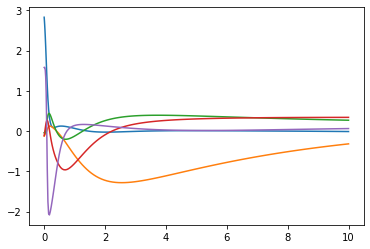

In [12]:
# t = np.linspace(0, T, num=200)
t = powspace(0, T, power=2, num=100)
for i in range(10000):
    _t = np.array(
        onp.concatenate([
            [0.0],onp.random.uniform(0,T, size=(100,)), [T] ]
            ))
    opt_state, copt_state = step(i, opt_state, copt_state, _t)
    if i % 100 == 0:
        clear_output(wait=True)
        x_params, u_params = get_params(opt_state)
        rho_params = get_params(copt_state)
        print(loss([x_params, u_params], rho_params,t))
        _x      = vmap(x_net,   in_axes=(None,0))(x_params, t).squeeze()
        _rho    = vmap(rho_net, in_axes=(None,0))(rho_params, t).squeeze()
        _u      = vmap(u_net,   in_axes=(None,0))(u_params, t).squeeze()
        plt.plot(t, _x)
        plt.plot(t, _u)
        plt.pause(0.1)